In [8]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import numpy as np

In [9]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        

        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [16]:
base_path = Path('drive/My Drive/dataset/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

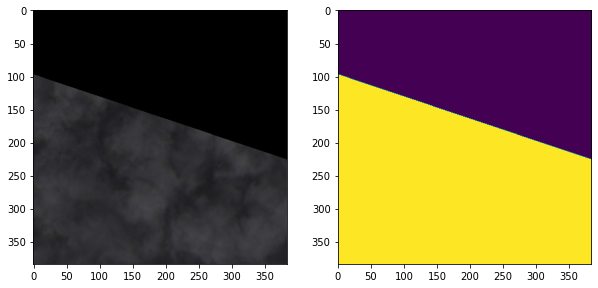

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(200))
ax[1].imshow(data.open_mask(200))

In [18]:
train_ds, valid_ds, test_ds = torch.utils.data.random_split(data, (5000, 1000, 2400))

In [19]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=True)

In [21]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([8, 4, 384, 384]), torch.Size([8, 384, 384]))

In [23]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

Модель

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as t_f

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNETBig(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=2, features=[64, 128, 256, 512],
    ):
        super(UNETBig, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = t_f.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    print(x.shape)
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    assert preds.shape == x.shape



In [24]:
unet = UNET(in_channels=4, out_channels=2)

In [25]:
torch.cuda.is_available()

True

In [ ]:
import time,os

from IPython.display import clear_output

output_dir = '/output'
os.makedirs(output_dir,exist_ok=True)


def train(model, train_dl, valid_dl,test_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    train_loss, valid_loss, test_loss = [], [], []

    best_acc = 0.0
    from tqdm import tqdm
    for epoch in tqdm(range(epochs)):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid', 'test']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            elif phase == 'valid':
                model.eval
                dataloader= valid_dl
            else:
                phase =='test'  # Set model to evaluate mode
                model.eval
                dataloader= valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1


                if phase == 'train':

                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)


                    loss.backward()
                    optimizer.step()


                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:

                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))


            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            if phase=='train' :
                train_loss.append(epoch_loss) 
            elif phase=='valid' :
                valid_loss.append(epoch_loss)
            else: test_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss, test_loss  

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [ ]:
torch.cuda.is_available()

True

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss, test_loss = train(unet, train_dl, valid_dl, test_dl, loss_fn, opt, acc_metric, epochs=50)


100%|██████████| 50/50 [5:44:43<00:00, 413.67s/it]

Epoch 49/49
----------
test Loss: 0.0999 Acc: 0.9633800983428955
----------
Training complete in 344m 46s


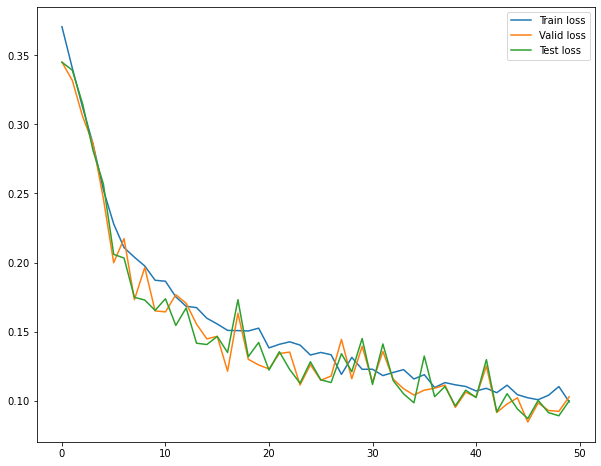

In [ ]:
plt.figure(figsize=(10,8)) 
plt.plot(train_loss, label='Train loss') 
plt.plot(valid_loss, label='Valid loss') 
plt.plot(test_loss, label='Test loss') 
plt.legend()

In [26]:
unet.load_state_dict(torch.load('drive/My Drive/unet_small_inf.pth'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
unet.to(device)
unet.eval

<bound method Module.eval of UNET(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
 

In [27]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [40]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([8, 2, 384, 384])

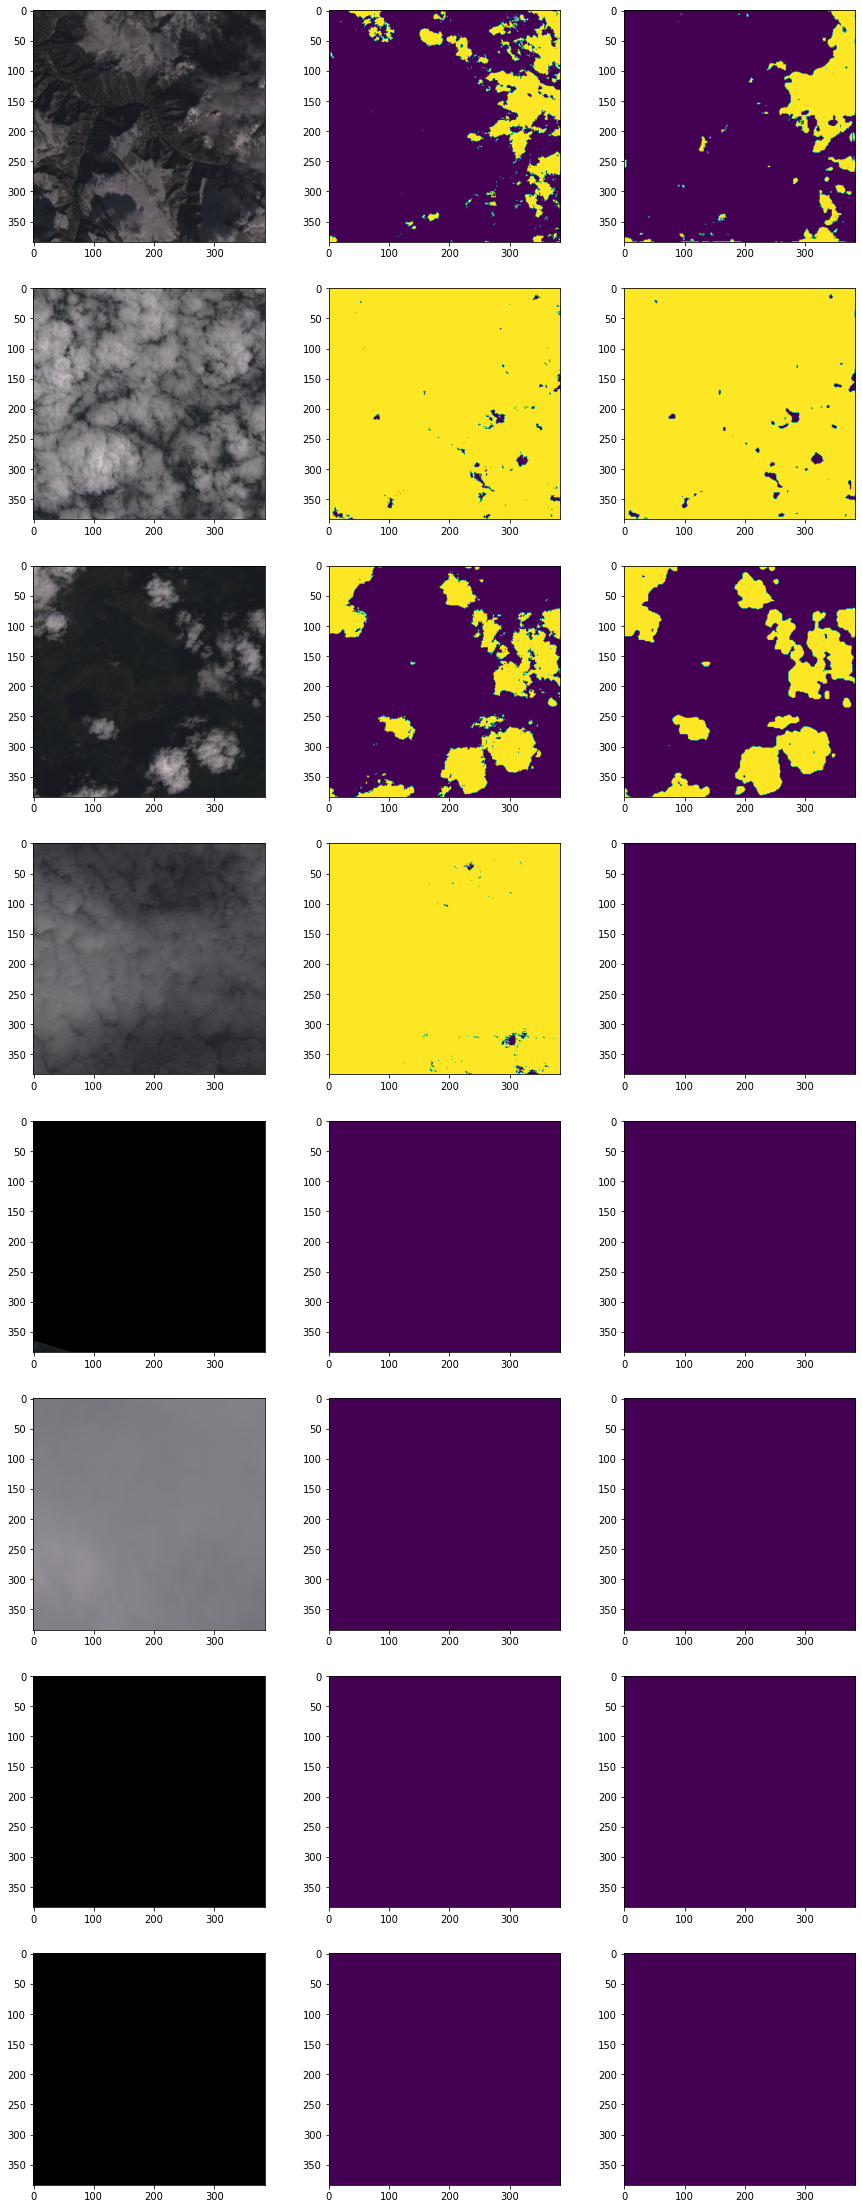

In [41]:
bs = 8
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [44]:
xb, yb = next(iter(test_dl))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([8, 2, 384, 384])

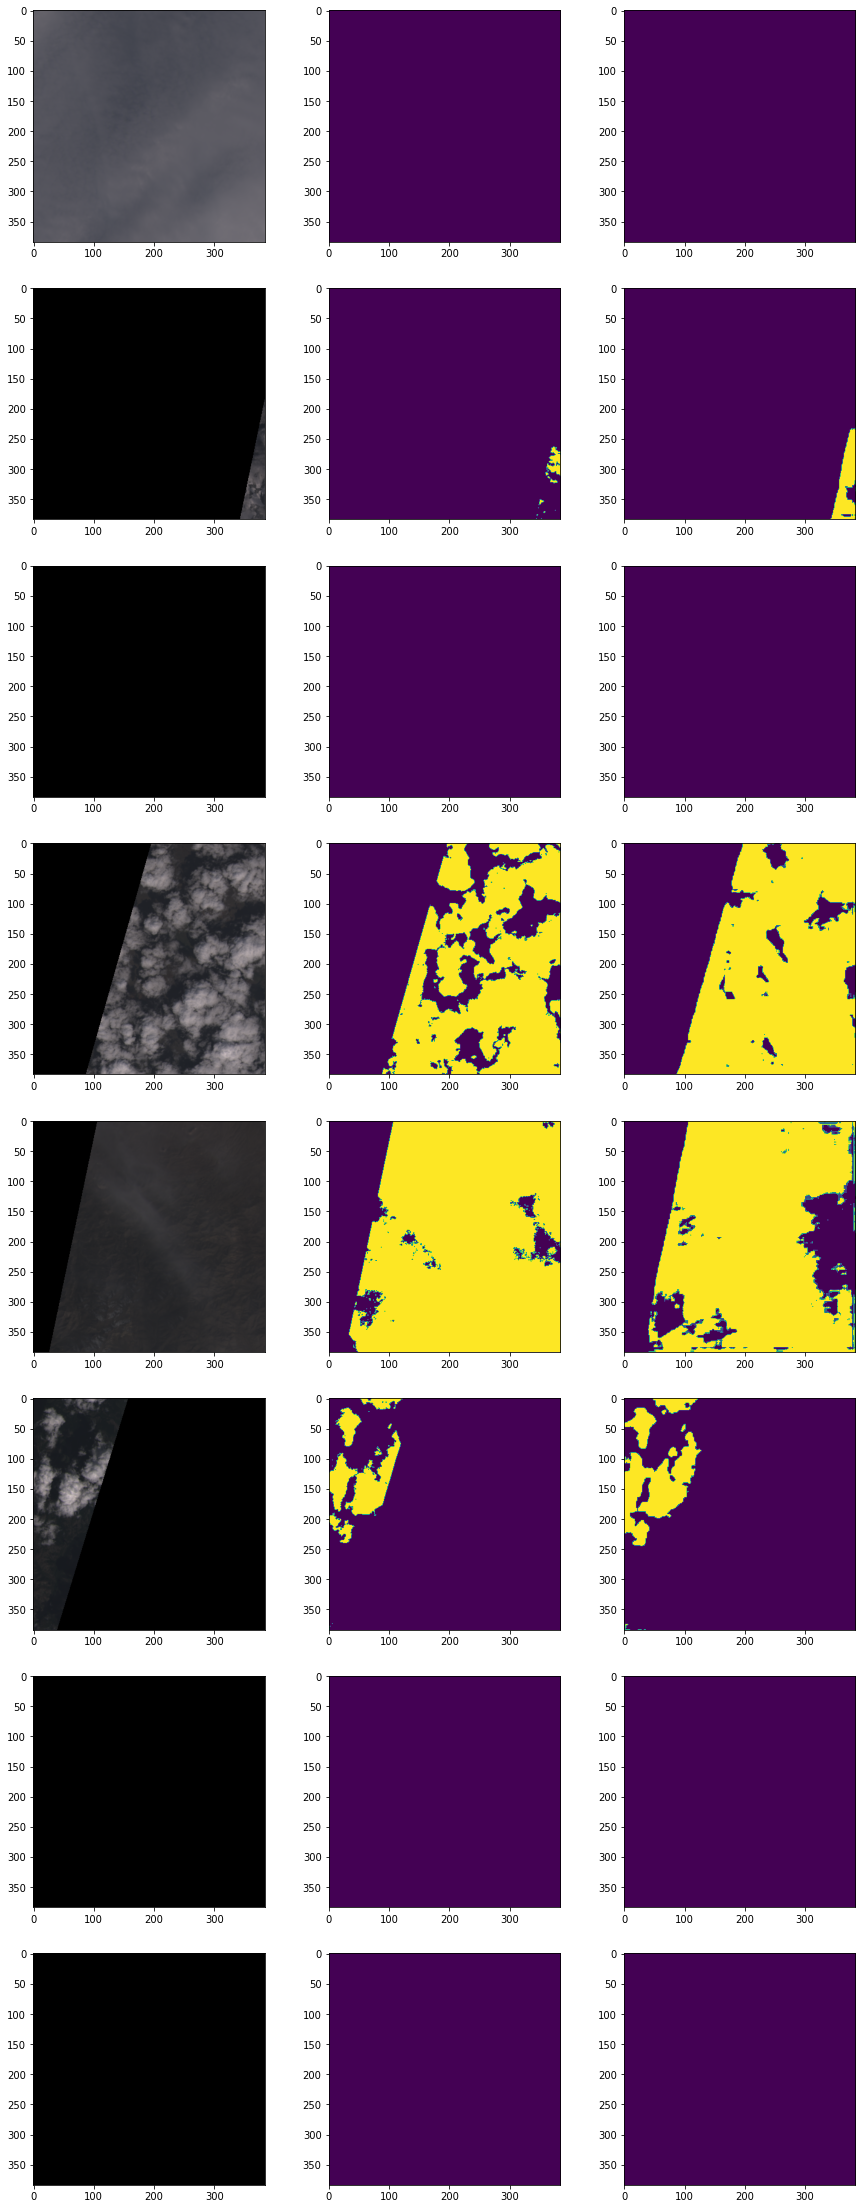

In [45]:
bs = 8
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [61]:
import sklearn.metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [54]:
total_f1 = 0
total_jaccard = 0
total_roc_auc = 0
preds = []
ans = []
k = 0
xb, yb = next(iter(test_dl))

for input,label in [[xb, yb]]:
    input = input.to(device)
    logit = unet(input)
    pred = logit.argmax(dim=1)
    preds.append(pred)
    ans.append(label)
    #matplotlib.image.imsave('pred' + str(k) +'.png', pred[0].cpu().numpy())
    #matplotlib.image.imsave('labels' + str(k) + '.png', label[0].cpu().numpy())
    trgt = label.cpu().detach().numpy().reshape(-1)
    res = logit.argmax(dim=1).cpu().detach().numpy().reshape(-1)
    jsc = sklearn.metrics.jaccard_similarity_score(trgt, res)
    f1 = sklearn.metrics.f1_score(trgt, res)
    roc_auc = sklearn.metrics.roc_auc_score(trgt, res)
    total_f1 += f1
    total_jaccard += jsc
    total_roc_auc += roc_auc
    print(f"{k} batch: ")
    #print("f1-score = ", f1)
    #print("jaccard score = ", jsc)
    #print("roc auc score = ", roc_auc)
    k += 1

print("Average metrics on valid dataset: \n")
print (f'Jaccard loss : {total_jaccard} \nFi-score : {total_f1} \nROC_AUC-score : {total_roc_auc}')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0 batch: 
Average metrics on valid dataset: 

Jaccard loss : 0.9705776638454862 
Fi-score : 0.9634754131483462 
ROC_AUC-score : 0.9693437862147581
